# Programming Assignment: Building a Translation System

## Introduction

Welcome to the final notebook in our transformer architecture series! After exploring attention mechanisms, encoder models, and decoder models separately, we now bring everything together to build a complete **Encoder-Decoder architecture** for neural machine translation.

The encoder-decoder architecture is the foundation of many sequence-to-sequence (seq2seq) tasks, particularly machine translation. This architecture allows us to transform an input sequence (like an English sentence) into an output sequence (like a French translation) by learning the complex mappings between languages.

### What You'll Learn

In this notebook, we will:
- Understand the complete encoder-decoder architecture and how it combines our previous components
- Implement a full transformer model for translation
- Train our model on English-to-French translation
- Evaluate and use our model to translate new sentences

### Prerequisites

This notebook assumes you've completed the previous notebooks on:
1. Attention mechanisms
2. Encoder architecture
3. Decoder architecture

---

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- - To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## 1 - Understanding the Encoder-Decoder Architecture

The encoder-decoder architecture is a powerful framework for sequence-to-sequence learning tasks. It consists of two main components working in tandem:

1. **The Encoder**: Processes the entire input sequence and creates a rich representation (context) of it
2. **The Decoder**: Takes this context and generates the output sequence step by step

Think of it as a two-stage translation process:
- First, the encoder "understands" the source sentence completely
- Then, the decoder "expresses" this understanding in the target language

### 1.1 How Encoder-Decoder Models Work

The encoder-decoder architecture follows these key principles:

1. **Encoding Phase**: The encoder processes the entire input sequence (e.g., an English sentence) and produces a sequence of hidden states that capture the meaning and context of each word in relation to the entire sentence.

2. **Context Passing**: The encoder's output (hidden states) is passed to the decoder as context. In transformer models, this happens through cross-attention mechanisms.

3. **Decoding Phase**: The decoder generates the output sequence one token at a time, using:
   - The encoder's context (through cross-attention)
   - Previously generated tokens (through self-attention)
   - Learned patterns from training data

4. **Autoregressive Generation**: During inference, the decoder generates tokens sequentially, where each new token depends on all previously generated tokens.

### 1.2 Key Components and Information Flow

The information flow in an encoder-decoder transformer can be visualized as:

```
Input Sequence → Encoder → Context Vectors → Decoder → Output Sequence
     (English)              (Hidden States)              (Desired language)
```

Each component plays a crucial role:
- **Encoder Self-Attention**: Helps each word understand its context within the source sentence
- **Decoder Self-Attention**: Ensures coherence in the generated target sequence
- **Cross-Attention**: Connects source and target, allowing the decoder to "look at" relevant parts of the input when generating each output word

## 1 - Understanding the Encoder-Decoder Architecture

The encoder-decoder architecture transforms input sequences into output sequences through two key components:

1. **Encoder**: Processes the entire input sequence and creates rich contextual representations
2. **Decoder**: Uses the encoder's context to generate the output sequence step-by-step

![Encoder-Decoder Architecture](images/encoder_decoder_architecture.svg)

### Key Information Flow

The architecture follows this pattern:
- **Encoder Self-Attention**: Each input word understands its context within the source sentence
- **Cross-Attention**: Decoder "looks at" relevant input parts when generating each output word  
- **Decoder Self-Attention**: Ensures coherence in the generated sequence
- **Autoregressive Generation**: Each new output token depends on previously generated tokens

This design enables effective sequence-to-sequence learning for tasks like machine translation.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

import numpy as np

# For data handling
from collections import Counter

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
import helper_utils
import unittests

### 2.2 Loading the Translation Dataset

In this assignment, you will work on a framework modular enough to be trained on datasets for different languages (but not a multi-language translator). Run the cell below to choose the language you want to work on for this assignment.

In [4]:
translation_pairs, target_language = helper_utils.load_dataset()

Available translation pairs (to/from English):
1. English ↔ French
2. English ↔ Spanish
3. English ↔ German
4. English ↔ Italian
5. English ↔ Portuguese
6. English ↔ Russian



Select a language (enter number):  1



You selected: English ↔ French
French dataset already extracted, loading...
Loaded 237838 English-French translation pairs

Random sample English-French pairs:
English: Do you know anyone who needs a job?
French: Connaissez-vous quelqu'un ayant besoin d'un emploi ?
--------------------------------------------------
English: Tom sealed the envelope.
French: Tom ferma l’enveloppe.
--------------------------------------------------
English: The war had lasted four years.
French: La guerre avait duré quatre ans.
--------------------------------------------------
English: At the party, one of his political opponents humiliated him in the presence of many guests.
French: À la fête, un de ses opposants politiques l'a humilié en présence de nombreux invités.
--------------------------------------------------
English: What makes you think I'm not happy?
French: Qu'est-ce qui te fait croire que je ne suis pas heureuse ?
--------------------------------------------------


### 2.3 Data Preprocessing and Tokenization

Before training a translation model, the text data needs to be properly preprocessed. This involves two key steps:

1. **Text Normalization**: Converting text to lowercase, handling special characters, and preserving language-specific features (like accents in French or umlauts in German)
2. **Tokenization**: Splitting sentences into individual tokens (words and punctuation) while preserving contractions like "he's" or "can't"

For this assignment, we've provided the preprocessing functions in the `helper_utils` module. This includes:
- `prepare_data()`: A function that normalizes your translation pairs and creates a language-appropriate tokenizer
- `MultilingualTokenizer`: A tokenizer class that handles multiple languages correctly
- `normalize_string()`: A function that cleans text while preserving important language features

**Note**: The preprocessing code is provided so you can focus on the core learning objective - building the encoder-decoder architecture. In practice, data preprocessing is crucial for model performance, but here we want you to concentrate on understanding the translation model itself.

To load and preprocess your data, run the cell below.


The function returns:
- `normalized_pairs`: A list of cleaned (English, Target Language) translation pairs
- `tokenizer`: A tokenizer object you can use to convert text to tokens

In [5]:
normalized_pairs, tokenizer = helper_utils.prepare_data(
    translation_pairs, 
    target_language,
    max_pairs=150000,  # Process first 150,000 pairs for faster training
    max_length=40      # Keep sentences with <= 40 words
)

# Cell 4: Check some normalized pairs
import random

print(f"\nRandom normalized {target_language} pairs:")
random_samples = random.sample(normalized_pairs, min(3, len(normalized_pairs)))
for eng, target in random_samples:
    print(f"EN: {eng}")
    print(f"{target_language}: {target}")
    print("-" * 40)

# Cell 5: Use the tokenizer on custom text
custom_text = "I love programming!"
tokens = tokenizer(custom_text)
print(f"\nCustom text: {custom_text}")
print(f"Tokens: {tokens}")


=== Tokenizer Test for French ===
Original: Hello, how are you?
Tokenized: ['hello', 'how', 'are', 'you', '?']

Original: He's going to the store.
Tokenized: ["he's", 'going', 'to', 'the', 'store', '.']

Original: I can't believe it's working!
Tokenized: ['i', "can't", 'believe', "it's", 'working', '!']

Original: They're here, aren't they?
Tokenized: ["they're", 'here', "aren't", 'they', '?']


French sample: va !
French tokenized: ['va', '!']

=== Data Preparation Complete ===
Normalized pairs: 150000 (from 150000 original pairs)

Random normalized French pairs:
EN: i'll never be as good as you .
French: je ne serai jamais aussi bonne que toi .
----------------------------------------
EN: i told you everything i knew .
French: je vous ai dit tout ce que je savais .
----------------------------------------
EN: read it again .
French: lis le de nouveau .
----------------------------------------

Custom text: I love programming!
Tokens: ['i', 'love', 'programming', '!']


## 3 - Building Vocabulary and Creating Data Loaders

### 3.1 Building Vocabularies

Now you'll build vocabularies for both source (English) and target languages using the same approach as in previous notebooks.

In [8]:
def build_vocab(sentences, tokenizer, min_freq=1):
    """
    Build vocabulary from sentences
    """
    counter = Counter()  # Counter to count word frequencies in all sentences
    for sent in sentences:
        counter.update(tokenizer(sent))  # Tokenize sentence and add token counts
    
    # Start vocab with special tokens for translation
    # <pad>: padding token, <unk>: unknown token, <sos>: start of sequence, <eos>: end of sequence
    vocab = ['<pad>', '<unk>', '<sos>', '<eos>'] + [w for w, c in counter.items() if c >= min_freq]
    
    # Create a mapping from word to unique index
    word2idx = {w: i for i, w in enumerate(vocab)}
    # Create a mapping from index back to word (inverse of word2idx)
    idx2word = {i: w for i, w in enumerate(vocab)}
    
    # Return the vocab list and the two dictionaries
    return vocab, word2idx, idx2word

In [9]:
# Extract English and target language sentences separately
eng_sentences = [eng for eng, tgt in normalized_pairs]
tgt_sentences = [tgt for eng, tgt in normalized_pairs]

# Build vocabularies for both languages
print("Building English vocabulary...")
eng_vocab, eng_word2idx, eng_idx2word = build_vocab(eng_sentences, tokenizer, min_freq=2)
print(f"English vocab size: {len(eng_vocab)}")
print(f"First 20 English vocab words: {eng_vocab[:20]}")

print(f"\nBuilding {target_language} vocabulary...")
tgt_vocab, tgt_word2idx, tgt_idx2word = build_vocab(tgt_sentences, tokenizer, min_freq=2)
print(f"{target_language} vocab size: {len(tgt_vocab)}")
print(f"First 20 {target_language} vocab words: {tgt_vocab[:20]}")

Building English vocabulary...
English vocab size: 8043
First 20 English vocab words: ['<pad>', '<unk>', '<sos>', '<eos>', 'go', '.', 'hi', 'run', '!', 'who', '?', 'wow', 'duck', 'fire', 'help', 'hide', 'jump', 'stop', 'wait', 'begin']

Building French vocabulary...
French vocab size: 13412
First 20 French vocab words: ['<pad>', '<unk>', '<sos>', '<eos>', 'va', '!', 'marche', '.', 'en', 'route', 'bouge', 'salut', 'cours', 'courez', 'prenez', 'vos', 'jambes', 'à', 'cous', 'file']


### 3.2 Preparing Translation Pairs

For the encoder-decoder model, you need to prepare pairs of sequences where each source sentence is paired with its target translation. You'll add special tokens to mark the beginning and end of sequences.

In [10]:
def prepare_sequence(sentence, tokenizer, word2idx, max_length=20, add_special_tokens=True):
    """
    Convert a sentence to a list of indices with special tokens
    """
    tokens = tokenizer(sentence)
    
    if add_special_tokens:
        # Add <sos> at the beginning and <eos> at the end
        tokens = ['<sos>'] + tokens + ['<eos>']
    
    # Convert tokens to indices
    indices = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
    
    # Pad or truncate to max_length
    if len(indices) < max_length:
        # Pad with <pad> tokens
        indices = indices + [word2idx['<pad>']] * (max_length - len(indices))
    else:
        # Truncate if too long
        indices = indices[:max_length]
    
    return indices

In [11]:
# Prepare all translation pairs
MAX_LENGTH = 40
prepared_pairs = []

for eng, tgt in normalized_pairs:
    # Prepare source (English) - no special tokens for encoder input
    eng_tokens = tokenizer(eng)
    eng_indices = [eng_word2idx.get(token, eng_word2idx['<unk>']) for token in eng_tokens]
    
    # Pad or truncate
    if len(eng_indices) < MAX_LENGTH:
        eng_indices = eng_indices + [eng_word2idx['<pad>']] * (MAX_LENGTH - len(eng_indices))
    else:
        eng_indices = eng_indices[:MAX_LENGTH]
    
    # Prepare target - with special tokens for decoder
    tgt_indices = prepare_sequence(tgt, tokenizer, tgt_word2idx, MAX_LENGTH, add_special_tokens=True)
    
    prepared_pairs.append((eng_indices, tgt_indices))

print(f"Number of prepared pairs: {len(prepared_pairs)}")

# Show an example pair
example_idx = 0
eng_indices, tgt_indices = prepared_pairs[example_idx]

print("\nExample prepared pair:")
print(f"Original English: {normalized_pairs[example_idx][0]}")
print(f"English tokens: {[eng_idx2word[i] for i in eng_indices if i != eng_word2idx['<pad>']]}")
print(f"English indices: {eng_indices}")

print(f"\nOriginal {target_language}: {normalized_pairs[example_idx][1]}")
print(f"{target_language} tokens: {[tgt_idx2word[i] for i in tgt_indices if i != tgt_word2idx['<pad>']]}")
print(f"{target_language} indices: {tgt_indices}")

Number of prepared pairs: 150000

Example prepared pair:
Original English: go .
English tokens: ['go', '.']
English indices: [4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Original French: va !
French tokens: ['<sos>', 'va', '!', '<eos>']
French indices: [2, 4, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### 3.3 Creating PyTorch Dataset and DataLoaders

You'll create a custom Dataset class to handle the data efficiently during training.

In [12]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    """
    PyTorch Dataset for translation pairs
    """
    def __init__(self, pairs):
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        src_indices, tgt_indices = self.pairs[idx]
        
        # Convert to tensors
        src_tensor = torch.tensor(src_indices, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt_indices, dtype=torch.long)
        
        return src_tensor, tgt_tensor

In [13]:
import torch
from torch.utils.data import DataLoader, Subset

# Create the full dataset
full_dataset = TranslationDataset(prepared_pairs)

# Create random indices for splitting
total_size = len(full_dataset)
indices = list(range(total_size))

# Shuffle indices with seed for reproducibility
torch.manual_seed(42)
indices = torch.randperm(total_size).tolist()

# Calculate split point
split_point = int(0.9 * total_size)

# Create train and validation indices
train_indices = indices[:split_point]
val_indices = indices[split_point:]

# Create subset datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

print(f"Training pairs: {len(train_dataset)}")
print(f"Validation pairs: {len(val_dataset)}")

# Create data loaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test the data loader
for src_batch, tgt_batch in train_loader:
    print(f"Source batch shape: {src_batch.shape}")
    print(f"Target batch shape: {tgt_batch.shape}")
    # Show first example from batch
    print(f"\nFirst example in batch:")
    src_tokens = [eng_idx2word[idx.item()] for idx in src_batch[0] if idx.item() != eng_word2idx['<pad>']]
    tgt_tokens = [tgt_idx2word[idx.item()] for idx in tgt_batch[0] if idx.item() != tgt_word2idx['<pad>']]
    print(f"Source (English): {' '.join(src_tokens)}")
    print(f"Target ({target_language}): {' '.join(tgt_tokens)}")
    break

Training pairs: 135000
Validation pairs: 15000
Source batch shape: torch.Size([64, 40])
Target batch shape: torch.Size([64, 40])

First example in batch:
Source (English): spit it out tom .
Target (French): <sos> crache la tom . <eos>


## 4 - Building the Encoder-Decoder Architecture

### 4.1 Helper Functions for Masking

Before building the model, you need helper functions to create masks. Masks are crucial in transformer-based models to control what information the model can "see" during processing. They prevent the model from:
1. Paying attention to padding tokens (which are just placeholders)
2. Cheating by looking at future tokens during training

#### Understanding Padding Masks

When we batch sequences together, they often have different lengths. We pad shorter sequences with zeros to make all sequences the same length:

```
Original sentences:
"I am" → ['I', 'am'] → [34, 67]
"She loves cats" → ['She', 'loves', 'cats'] → [12, 89, 45]

After padding (assuming max_length=5):
[34, 67, 0, 0, 0]  # "I am" + padding
[12, 89, 45, 0, 0]  # "She loves cats" + padding
```

The padding mask tells the model to ignore these padding positions:

In [14]:
def create_padding_mask(seq, pad_idx=0):
    """
    Create a mask to hide padding tokens
    Args:
        seq: Input sequence tensor [batch_size, seq_length]
        pad_idx: Index used for padding (usually 0)
    Returns:
        Boolean mask where True = ignore this position
    """
    return (seq == pad_idx)

In [15]:
padded_seq = create_padding_mask(np.array([34, 67, 0, 0, 0]))
print(padded_seq)

[False False  True  True  True]


**Example:**
```
Input sequence: [34, 67, 0, 0, 0]
Padding mask:   [False, False, True, True, True]
                   ↑      ↑      ↑     ↑     ↑
                 Keep   Keep  Ignore Ignore Ignore
```

#### Understanding Causal Masks (Look-Ahead Masks)

During training, the decoder generates tokens one at a time. To prevent it from "cheating" by looking at future tokens it hasn't generated yet, we use a causal mask:

In [16]:
def make_causal_mask(size):
    """
    Create a mask to hide future tokens (for decoder self-attention)
    Args:
        size: Sequence length
    Returns:
        Upper triangular matrix where True = ignore this position
    """
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask

In [17]:
# Example: Decoder input with padding
decoder_input = ['<sos>', 'Hello', 'world', '<pad>', '<pad>']
indices = [2, 34, 67, 0, 0]

# Create both masks
padding_mask = create_padding_mask(indices)  # [F, F, F, T, T]
subsequent_mask = make_causal_mask(5)   # Upper triangular matrix
print(subsequent_mask)

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


Combined effect:
- Position 0: Can see position 0 only (not padding)
- Position 1: Can see positions 0-1 (not padding)
- Position 2: Can see positions 0-2 (not padding)
- Positions 3-4: Ignored (they're padding)

### 4.2 Positional Encoding

Transformers, unlike RNNs or LSTMs, process all tokens in a sequence simultaneously through attention mechanisms. This parallel processing is powerful but comes with a limitation: the model has no inherent understanding of word order. Without position information, "The cat chased the dog" would be indistinguishable from "The dog chased the cat" to the model.

Positional encoding solves this by adding position-dependent signals to the word embeddings. These signals use sinusoidal functions with different frequencies - think of it like giving each position in the sequence a unique "signature" that the model can learn to interpret. The clever use of sine and cosine functions at different frequencies allows the model to learn relative positions (how far apart two words are) and absolute positions (where in the sentence a word appears). This positional information is simply added to the word embeddings, allowing the model to distinguish between the same word appearing in different positions.

In [18]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to token embeddings using sinusoidal patterns.
    
    Since transformers don't have inherent notion of sequence order (unlike RNNs),
    we add positional encodings to give the model information about where each
    token appears in the sequence.
    """
    def __init__(self, max_len, d_model):
        """
        Initialize positional encoding matrix.
        
        Args:
            max_len (int): Maximum sequence length the model will handle
                          (e.g., 100 for sentences up to 100 tokens)
            d_model (int): Dimension of the model's embeddings 
                          (e.g., 256 or 512 - must match embedding size)
        
        Creates a fixed sinusoidal pattern matrix of shape [max_len, d_model]
        where each row represents the positional encoding for that position.
        """
        super().__init__()

        self.max_len = max_len
        self.d_model = d_model
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        # Create div_term for the sinusoidal pattern
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(torch.log(torch.tensor(10000.0)) / d_model))
        
        # Apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cos to odd indices  
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not trained, but saved with model)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        """
        Add positional encoding to input embeddings.
        
        Args:
            x (Tensor): Token embeddings of shape [batch_size, seq_len, d_model]
                       where seq_len <= max_len from initialization
        
        Returns:
            Tensor: Positional encodings of shape [batch_size, seq_len, d_model]
                   (same shape as input, ready to be added to embeddings)
        
        Example:
            If x represents embeddings for "I love cats" (3 tokens):
            - Input x shape: [batch_size, 3, 256]
            - Output shape: [batch_size, 3, 256]
            - Returns positions 0, 1, 2 encoded as 256-dim vectors
        """
        seq_len = x.size(1)
        return self.pe[:, :seq_len, :]

### 4.3 Complete Translator Model

Now you'll build the complete Translator model that combines encoder and decoder using PyTorch's built-in transformer layers.

### Exercise 1 - The Encoder Part

In this exercise, you'll build the **Encoder** component of our translation model. The encoder is responsible for reading and understanding the source language (English in our case) and creating a rich contextual representation that captures the meaning of the entire sentence.

#### What You'll Build:

The encoder processes source sentences through the following steps:

1. **Token Embedding**: Convert word indices to dense vectors
2. **Positional Encoding**: Add position information (since transformers don't inherently understand word order)
3. **Transformer Encoding**: Apply self-attention to understand relationships between all words in the source sentence
4. **Output Memory**: Generate contextualized representations that the decoder will use for translation

#### Your Task:

Complete the `Encoder` class by filling in the missing code where you see `None`. Follow the inline comments that guide you through each step:

- Initialize the embedding layer with the correct vocabulary size and dimensions
- Add positional encoding to give the model sequence order information
- Create transformer encoder layers with the specified architecture
- Implement the forward pass to process input sentences

#### Key Concepts to Remember:

- **Padding Index**: We use index 0 for padding tokens (to handle variable-length sentences)
- **Batch First**: We set `batch_first=True` to keep dimensions intuitive `[batch_size, seq_len, d_model]`
- **Memory**: The encoder output is called "memory" because the decoder will repeatedly reference it during translation

#### Expected Output:

After completing this exercise, your encoder should:
- Accept batches of tokenized source sentences
- Return memory representations and padding masks
- Handle variable-length inputs through padding and masking

<details>
<summary><h4 style="color:green; cursor:pointer;">💡 Click here for detailed hints</h4></summary>

### Hint 1: Token Embedding Layer

**What you need**: Create an embedding layer that converts token indices to dense vectors.

**Key points**:
- PyTorch provides `nn.Embedding(num_embeddings, embedding_dim, padding_idx)` for this
- `num_embeddings` should be the size of your source vocabulary (passed as `vocab_size` parameter)
- `embedding_dim` should match your model dimension (the `d_model` parameter)
- Set `padding_idx=0` so the model learns to ignore padding tokens

**Example structure**:
```python
self.token_emb = nn.Embedding(
    num_embeddings=?,  # vocab_size
    embedding_dim=?,   # d_model
    padding_idx=0
)
```

---

### Hint 2: Positional Encoding

**What you need**: Add positional information to help the model understand word order.

**Key points**:
- The `PositionalEncoding` class is already implemented for you above
- You need to instantiate it with the correct parameters
- It requires `max_len` (maximum sequence length) and `d_model` (embedding dimension)
- Both parameters are passed to the `__init__` method

**Example structure**:
```python
self.pos_enc = PositionalEncoding(
    max_len=?,   # Parameter from __init__
    d_model=?    # Parameter from __init__
)
```

---

### Hint 3: Transformer Encoder Layer

**What you need**: Create a single transformer encoder layer with multi-head attention.

**Key points**:
- Use `nn.TransformerEncoderLayer` from PyTorch
- Required parameters:
  - `d_model`: Model dimension (hidden size)
  - `nhead`: Number of attention heads
  - `dim_feedforward`: Dimension of the feedforward network
  - `dropout`: Dropout rate for regularization
  - `batch_first=True`: Keep batch dimension first for intuitive tensor shapes
- All these parameters are passed to your `__init__` method

**Example structure**:
```python
encoder_layer = nn.TransformerEncoderLayer(
    d_model=?,           # From parameter
    nhead=?,             # From parameter
    dim_feedforward=?,   # From parameter
    dropout=?,           # From parameter
    batch_first=True     # Important!
)
```

---

### Hint 4: Stacking Multiple Encoder Layers

**What you need**: Stack multiple encoder layers to create a deep encoder.

**Key points**:
- Use `nn.TransformerEncoder` to stack multiple layers
- It takes the encoder layer you just created and the number of layers
- `num_layers` parameter determines the depth

**Example structure**:
```python
self.transformer_encoder = nn.TransformerEncoder(
    encoder_layer=?,   # The encoder_layer you created above
    num_layers=?       # From parameter
)
```

---

### Hint 5: Forward Pass - Embedding and Positional Encoding

**What you need**: Convert tokens to embeddings and add positional information.

**Key points**:
- First, embed the tokens using `self.token_emb(x)`
- Then, get positional encodings using `self.pos_enc(x)`
- Add them together: `embeddings + positional_encodings`
- The result should be a tensor of shape `[batch_size, seq_len, d_model]`

**Example structure**:
```python
x = self.token_emb(?) + self.pos_enc(?)
```

---

### Hint 6: Forward Pass - Applying Dropout

**What you need**: Apply dropout for regularization.

**Key points**:
- Use the `self.dropout` layer that's already defined
- Pass the embedded + positional encoded tensor through it
- This randomly zeros some elements during training to prevent overfitting

**Example structure**:
```python
x = self.dropout(?)  # Apply to the embedded tensor
```

---

### Hint 7: Forward Pass - Transformer Encoder

**What you need**: Pass the embeddings through the transformer encoder layers.

**Key points**:
- Use `self.transformer_encoder` that you created in `__init__`
- It needs two inputs:
  1. The embedded tensor (with positional encoding and dropout applied)
  2. The padding mask (via `src_key_padding_mask` parameter)
- The padding mask tells the encoder which positions to ignore (where padding tokens are)

**Example structure**:
```python
memory = self.transformer_encoder(
    ?,                           # The embedded tensor
    src_key_padding_mask=?       # The padding_mask created earlier
)
```

---

### Summary of the Forward Pass Flow:

```
Input indices [batch, seq_len]
    ↓
Token Embedding [batch, seq_len, d_model]
    ↓
+ Positional Encoding [batch, seq_len, d_model]
    ↓
Dropout
    ↓
Transformer Encoder (with padding mask)
    ↓
Memory (contextualized representations) [batch, seq_len, d_model]
```

</details>

Let's start building the foundation of our translation model!

In [19]:
# GRADED CELL  

class Encoder(nn.Module):
    """
    Encoder: Processes the source language (English) and creates a context representation
    """
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3, 
                 dim_feedforward=512, max_len=100, dropout=0.1):
        super().__init__()

        ### START CODE HERE ###
        
        # Token embedding: Converts word indices to vectors with input dimension vocab_size, output dimension d_model and the padding_idx being the index 0
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        
        # Generate the positional encoding, by calling the previous defined layer PositionalEncoding, with max length given by max_len and d_model being the embedding dimension
        self.pos_enc = PositionalEncoding(max_len, d_model)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout) 
         
        # Define the encoder, by calling nn.TransformerEncoderLayer with the appropriate parameters. Do not forget th pass the dropout value! Include the parameter batch_first = None
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)

        # Set the transformer encoder layer by calling the nn.TransformerEncoder with the encoder_layer and the number of layers (given by the parameter)
        self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers)

        ### END CODE HERE ###
        
    def forward(self, src):
        """
        Args:
            src: Source language token indices [batch_size, seq_len]
        Returns:
            memory: Encoded representation [batch_size, seq_len, d_model]
        """
        ### START CODE HERE ###
        
        # Create padding mask
        padding_mask = create_padding_mask(src)
        
        # Embed tokens and add positional encoding
        # Note: We reuse the variable 'src' to save memory, changing it from indices to embeddings
        src = self.token_emb(src)
        src = src + self.pos_enc(src)
        
        # Perform dropout using the dropout layer defined above.
        src = self.dropout(src)
        
        # Pass through transformer encoder, by generating the contextual representation and the padding mask, passed in the argument called src_key_padding_mask
        memory = self.transformer_encoder(src, src_key_padding_mask=padding_mask)

        ### END CODE HERE ###
        
        return memory, padding_mask

In [20]:
unittests.exercise_1(Encoder)

 All tests passed!


In [21]:
# Usage
encoder = Encoder(
                vocab_size=5000,
                d_model=256,
                nhead=8,
                num_layers=3,
                dim_feedforward=512,
                max_len=100,
                dropout=0.1
)

helper_utils.show_model_layers(encoder)


 Encoder - Main Layers

Layer                          Type                           Parameters
----------------------------------------------------------------------
token_emb                      Embedding                       1,280,000
pos_enc                        PositionalEncoding                      0
dropout                        Dropout                                 0
transformer_encoder            TransformerEncoder              1,581,312
----------------------------------------------------------------------
TOTAL                                                          2,861,312


**Expected Output**

```
======================================================================
 TranslationEncoder - Main Layers
======================================================================

Layer                          Type                           Parameters
----------------------------------------------------------------------
token_emb                      Embedding                       1,280,000
pos_enc                        PositionalEncoding                      0
dropout                        Dropout                                 0
transformer_encoder            TransformerEncoder              1,581,312
----------------------------------------------------------------------
TOTAL                                                          2,861,312
======================================================================
```

### Exercise 2 - The Decoder Part

In this exercise, you'll build the **Decoder** component of our translation model. Unlike the generation-only decoder from Lab 3, this decoder is specifically designed for **translation** and includes cross-attention to encoder outputs.

#### How This Decoder Differs from Lab 3

| Aspect | Lab 3 Decoder (Generation) | Assignment Decoder (Translation) |
|--------|---------------------------|----------------------------------|
| **Primary Task** | Text generation (Shakespeare) | Translation (English → French) |
| **Input Source** | Only previous tokens | Previous tokens + Encoder memory |
| **Attention Types** | Self-attention only | Self-attention + Cross-attention |
| **Key Component** | `TransformerEncoder` with masking | `TransformerDecoder` with memory |
| **Memory Input** | ❌ None | ✅ Encoder outputs |

#### Translation Decoder Architecture

```
Target Tokens → Embedding → Positional Encoding
                ↓
         ┌─────────────────┐
         │  Decoder Block  │
         │                 │
         │ Self-Attention  │ ← Causal mask (no future peeking)
         │       ↓         │
         │ Cross-Attention │ ← Attends to encoder memory  
         │       ↓         │
         │ Feed Forward    │
         └─────────────────┘
                ↓
         Output Projection → Vocabulary Logits
```

#### 🔑 Critical Difference: Understanding Memory Masks

This is a key concept that's often confusing. Let's clarify when and why we use different masks:

**In Lab 3 (Generation-Only Decoder):**
```python
# Lab 3: Only decoder, no encoder - "memory" is the same target sequence
decoded = self.transformer_decoder(
    x,                        # Target sequence
    x,                        # Same target sequence used as "memory"
    tgt_mask=causal_mask,     # Causal mask for target self-attention  
    memory_mask=causal_mask,  # SAME causal mask for fake "cross-attention"
    ...
)
```
- **Why `memory_mask=causal_mask`?** Because there's no real encoder - the decoder attends to itself
- Both self-attention and "cross-attention" need causal masking to prevent future peeking

**In This Assignment (Translation Decoder):**
```python
# Assignment: Real encoder-decoder translation  
decoded = self.transformer_decoder(
    x,                        # Target sequence
    memory,                   # ENCODER OUTPUT (source language)
    tgt_mask=causal_mask,     # Causal mask for target self-attention
    memory_mask=None,         # NO mask for cross-attention to source
    ...
)
```
- **Why `memory_mask=None`?** Because we want to see **ALL source words** when generating each target word
- The source sentence is complete and static - no causal constraint needed
- Cross-attention should freely attend to any source position

#### 🎯 The Key Insight:

| Decoder Type | Memory Content | Memory Mask | Reason |
|--------------|----------------|-------------|---------|
| **Lab 3 (Generation)** | Target sequence (itself) | `causal_mask` | Prevent future peeking in autoregressive generation |
| **Assignment (Translation)** | Encoder output (source) | `None` | Allow full attention to complete source sentence |

**Translation Example:**
```
Source:  ["I", "love", "cats"]           ← ENCODER OUTPUT
Target:  [<sos>, "Eu", "amo", ...]       ← DECODER INPUT  
Cross-attention: Can see ALL source words ← NO MASK NEEDED
```

#### Key Components You'll Implement:

1. **Target Embedding & Positional Encoding**: Convert target language tokens to vectors with position information
2. **Causal Masking**: Prevent decoder from seeing future tokens (maintains autoregressive property)  
3. **Cross-Attention Decoder**: Use `TransformerDecoderLayer` that can attend to encoder memory
4. **Output Projection**: Convert hidden states to target vocabulary probabilities

<details>
<summary><h4 style="color:green; cursor:pointer;">💡 Click here for detailed hints</h4></summary>

### Hint 1: Token Embedding for Target Language

**What you need**: Create an embedding layer for target language tokens.

**Key points**:
- Very similar to the encoder's embedding layer
- Use `nn.Embedding(vocab_size, d_model, padding_idx=0)`
- The `vocab_size` here is for the **target** language vocabulary
- Must have the same `d_model` as the encoder for compatibility

**Example structure**:
```python
self.token_emb = nn.Embedding(
    num_embeddings=?,  # vocab_size parameter
    embedding_dim=?,   # d_model parameter
    padding_idx=0
)
```

---

### Hint 2: Positional Encoding for Target Sequence

**What you need**: Add positional information to target token embeddings.

**Key points**:
- Same as encoder - use the `PositionalEncoding` class
- Instantiate with `max_len` and `d_model` parameters
- This helps the decoder understand the order of generated words

**Example structure**:
```python
self.pos_enc = PositionalEncoding(?, ?)
```

---

### Hint 3: Transformer Decoder Layer

**What you need**: Create a decoder layer (NOT an encoder layer!).

**Key points**:
- Use `nn.TransformerDecoderLayer` (this is different from Exercise 1!)
- This layer has both self-attention AND cross-attention
- Parameters are the same: `d_model`, `nhead`, `dim_feedforward`, `dropout`, `batch_first=True`

**Example structure**:
```python
decoder_layer = nn.TransformerDecoderLayer(
    d_model=?,
    nhead=?,
    dim_feedforward=?,
    dropout=?,
    batch_first=True
)
```

---

### Hint 4: Stacking Decoder Layers

**What you need**: Stack multiple decoder layers together.

**Key points**:
- Use `nn.TransformerDecoder` (note: Decoder, not Encoder!)
- Pass the decoder layer and the number of layers
- Creates a deep decoder with multiple layers of self-attention and cross-attention

**Example structure**:
```python
self.transformer_decoder = nn.TransformerDecoder(?, ?)
```

---

### Hint 5: Output Projection Layer

**What you need**: Convert decoder hidden states to vocabulary logits.

**Key points**:
- Use `nn.Linear` to project from `d_model` to `vocab_size`
- Input dimension: `d_model` (hidden state size)
- Output dimension: `vocab_size` (target vocabulary size)
- This produces a score for each word in the target vocabulary

**Example structure**:
```python
self.output_projection = nn.Linear(?, ?)  # in_features, out_features
```

---

### Hint 6: Forward Pass - Creating the Causal Mask

**What you need**: Create a mask to prevent the decoder from seeing future tokens.

**Key points**:
- Use the `make_causal_mask()` function that's already provided
- Pass the sequence length: `tgt.size(1)` gives you the length of the target sequence
- Move the mask to the same device as your input: `.to(tgt.device)`

**Example structure**:
```python
x_seq_len = tgt.size(1)
x_subsequent_mask = make_causal_mask(?).to(?)
```

---

### Hint 7: Forward Pass - Embedding with Scaling

**What you need**: Embed tokens and scale by sqrt(d_model).

**Key points**:
- First embed: `self.token_emb(tgt)`
- Then multiply by `math.sqrt(self.d_model)`
- This scaling is a common practice in transformer models to prevent vanishing gradients
- You'll need to import `math` module

**Example structure**:
```python
x = self.token_emb(tgt) * math.sqrt(self.d_model)
```

---

### Hint 8: Forward Pass - Adding Positional Encoding

**What you need**: Add positional information to the scaled embeddings.

**Key points**:
- Get positional encodings: `self.pos_enc(tgt)`
- Add to the embedded tensor: `tgt + positional_encoding`
- Simple addition works because both have shape `[batch, seq_len, d_model]`

**Example structure**:
```python
tgt = tgt + self.pos_enc(?)
```

---

### Hint 9: Forward Pass - Applying Dropout

**What you need**: Apply dropout regularization.

**Key points**:
- Use `self.dropout` layer
- Apply to the embedded + positional encoded tensor

**Example structure**:
```python
x = self.dropout(?)
```

---

### Hint 10: Forward Pass - The Decoder (Most Important!)

**What you need**: Pass through the transformer decoder with cross-attention to encoder memory.

**Key points**:
- Use `self.transformer_decoder`
- **First positional argument**: Target sequence (the embedded tensor `x`)
- **Second positional argument**: Encoder memory (passed as `memory` parameter)
- **`tgt_mask`**: The causal mask you created (`x_subsequent_mask`)
- **`memory_mask`**: Set to `None` (we want to see ALL source words!)
- **`tgt_key_padding_mask`**: Target padding mask (`x_padding_mask`)
- **`memory_key_padding_mask`**: Source padding mask (passed as `memory_padding_mask` parameter)

**Example structure**:
```python
decoded = self.transformer_decoder(
    ?,                              # Target sequence (x)
    ?,                              # Encoder memory
    tgt_mask=?,                     # Causal mask
    memory_mask=None,               # No mask for source!
    tgt_key_padding_mask=?,         # Target padding
    memory_key_padding_mask=?       # Source padding
)
```

---

### Hint 11: Forward Pass - Final Layer Norm

**What you need**: Apply layer normalization for training stability.

**Key points**:
- Use `self.ln_final` that's already defined
- Apply to the decoded tensor

**Example structure**:
```python
x = self.ln_final(?)
```

---

### Hint 12: Forward Pass - Output Projection

**What you need**: Project to vocabulary size to get logits.

**Key points**:
- Use `self.output_projection`
- Apply to the normalized decoded tensor
- Output shape: `[batch_size, seq_len, vocab_size]`

**Example structure**:
```python
output = self.output_projection(?)
```

---

### Summary of the Forward Pass Flow:

```
Target indices [batch, seq_len]
    ↓
Token Embedding (scaled) [batch, seq_len, d_model]
    ↓
+ Positional Encoding
    ↓
Dropout
    ↓
Transformer Decoder
  - Self-Attention (with causal mask)
  - Cross-Attention (to encoder memory, no mask!)
  - Feed Forward
    ↓
Layer Normalization
    ↓
Output Projection
    ↓
Logits [batch, seq_len, vocab_size]
```

</details>

#### Expected Behavior:

Your decoder should:
- ✅ Accept target sequences AND encoder memory (unlike Lab 3)
- ✅ Generate predictions for the next token at each position  
- ✅ Use cross-attention to "look at" relevant source words
- ✅ Properly mask future tokens during training
- ✅ Output logits over the entire target vocabulary

In [22]:
# GRADED CELL  

class Decoder(nn.Module):
    """
    Decoder component for translation (works with encoder output)
    """
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3,
                 dim_feedforward=512, max_len=100, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        
        ### START CODE HERE ###
        
        # Token embedding: Converts target word indices to vectors with input dimension vocab_size, output dimension d_model and the padding_idx being the index 0
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        
        # Generate the positional encoding for target sequence
        self.pos_enc = PositionalEncoding(max_len, d_model)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout) 
        
        # Define the decoder layer with the desired parameters
        dec_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        
        # Set the transformer decoder by passing the decoder layer and the number of layers
        self.transformer_decoder = nn.TransformerDecoder(dec_layer, num_layers)
        
        # Output projection layer: Projects decoder output to target vocabulary size, it must input the d_model and output vocab_size
        self.output_projection = nn.Linear(d_model, vocab_size)
        
        ### END CODE HERE ###
        
    def forward(self, tgt, memory, memory_padding_mask=None):
        """
        Args:
            tgt: Target language token indices [batch_size, tgt_seq_len]
            memory: Encoder output [batch_size, src_seq_len, d_model]
            memory_padding_mask: Mask for encoder padding [batch_size, src_seq_len]
        Returns:
            output: Predicted token logits [batch_size, tgt_seq_len, vocab_size]
        """
        ### START CODE HERE ###
        
        # Create padding mask for target sequence
        tgt_padding_mask = create_padding_mask(tgt)
        
        # Create subsequent mask to prevent decoder from looking at future tokens
        tgt_seq_len = tgt.size(1)
        tgt_subsequent_mask = make_causal_mask(tgt_seq_len).to(tgt.device)

        # Convert into token embeddings
        # Note: Hints specifically mention scaling by sqrt(d_model) for the decoder
        tgt = self.token_emb(tgt) * math.sqrt(self.d_model)
        
        # Add positional encoding so model knows word positions
        tgt = tgt + self.pos_enc(tgt)
        
        # Apply dropout to embedded target
        tgt = self.dropout(tgt)
        
        # Pass through transformer decoder with cross-attention to encoder memory
        decoded = self.transformer_decoder(
            tgt, 
            memory, 
            tgt_mask=tgt_subsequent_mask, 
            memory_mask=None, 
            tgt_key_padding_mask=tgt_padding_mask, 
            memory_key_padding_mask=memory_padding_mask
        )

        # Project decoder output to vocabulary size
        output = self.output_projection(decoded)
        
        ### END CODE HERE ###
        
        return output

In [23]:
decoder = Decoder(vocab_size=5000, d_model=256, nhead=8, num_layers=3)
helper_utils.show_decoder_layers(decoder)


 Decoder - Main Layers

Layer                          Type                           Parameters
----------------------------------------------------------------------
token_emb                      Embedding                       1,280,000
pos_enc                        PositionalEncoding                      0
dropout                        Dropout                                 0
transformer_decoder            TransformerDecoder              2,372,352
output_projection              Linear                          1,285,000
----------------------------------------------------------------------
TOTAL                                                          4,937,352


**Expected Output**
```
======================================================================
 Decoder - Main Layers
======================================================================

Layer                          Type                           Parameters
----------------------------------------------------------------------
token_emb                      Embedding                       1,280,000
pos_enc                        PositionalEncoding                      0
dropout                        Dropout                                 0
transformer_decoder            TransformerDecoder              2,372,352
output_projection              Linear                          1,285,000
----------------------------------------------------------------------
TOTAL                                                          4,937,352
======================================================================
```

In [24]:
unittests.exercise_2(Decoder)

 All tests passed!


### Exercise 3 - The Grand Finale: The EncoderDecoder

Congratulations on building the encoder and decoder! Now it's time to bring them together into a complete translation system. In this final exercise, you'll create the **EncoderDecoder** model that orchestrates the full translation pipeline.

#### What You'll Build:

The complete translation model that:

1. **Reads** the source language (via the Encoder)
2. **Understands** the meaning and context
3. **Generates** the target language translation (via the Decoder)

This is where your previous work comes together into a functioning translator!

#### Your Task:

Complete the `EncoderDecoder` class by:

- Instantiating the Encoder with source language vocabulary
- Instantiating the Decoder with target language vocabulary  
- Connecting them in the forward pass to perform translation

The implementation is straightforward but powerful - you're wiring together the components you've already built.

#### Key Design Decisions:

- **Separate Vocabularies**: Source and target languages have different vocabulary sizes (e.g., English: 5000 words, Target Language: 6000 words)
- **Separate Layer Counts**: You can have different depths for encoder and decoder (e.g., 3 encoder layers, 4 decoder layers)
- **Shared Dimensions**: Both components must use the same `d_model` to ensure compatibility

#### The Translation Flow:
**Example in Portuguese**

```
English "I love cats" → [ENCODER] → Memory (understanding)
                                          ↓
Portuguese "<sos> Eu amo" → [DECODER + Memory] → "gatos" (next word)
```

#### Expected Output:

After completing this exercise, you'll have a model that:
- Accepts source sentences in one language
- Accepts partial target sentences during training
- Outputs probability distributions over target vocabulary
- Can be trained end-to-end for translation

<details>
<summary><h4 style="color:green; cursor:pointer;">💡 Click here for detailed hints</h4></summary>

### Hint 1: Instantiating the Encoder

**What you need**: Create an encoder instance for the source language.

**Key points**:
- Use the `Encoder` class you implemented in Exercise 1
- The encoder needs to know the source vocabulary size
- Pass `src_vocab_size` for the `vocab_size` parameter
- Pass all the other model parameters: `d_model`, `nhead`, `num_enc_layers` (for `num_layers`), etc.
- Make sure to use `num_enc_layers` (not `num_dec_layers`) for the encoder depth

**Example structure**:
```python
self.encoder = Encoder(
    vocab_size=?,          # Source vocabulary size
    d_model=?,             # Model dimension
    nhead=?,               # Number of attention heads
    num_layers=?,          # Number of ENCODER layers
    dim_feedforward=?,     # Feedforward dimension
    max_len=?,             # Maximum sequence length
    dropout=?              # Dropout rate
)
```

**What parameters to use?**
- `vocab_size` → `src_vocab_size` (from `__init__` parameters)
- `num_layers` → `num_enc_layers` (from `__init__` parameters)
- All others → pass directly from `__init__` parameters

---

### Hint 2: Instantiating the Decoder

**What you need**: Create a decoder instance for the target language.

**Key points**:
- Use the `Decoder` class you implemented in Exercise 2
- The decoder needs to know the target vocabulary size
- Pass `tgt_vocab_size` for the `vocab_size` parameter
- Pass all the other model parameters
- Use `num_dec_layers` (not `num_enc_layers`) for the decoder depth

**Example structure**:
```python
self.decoder = Decoder(
    vocab_size=?,          # Target vocabulary size
    d_model=?,             # Model dimension (must match encoder!)
    nhead=?,               # Number of attention heads
    num_layers=?,          # Number of DECODER layers
    dim_feedforward=?,     # Feedforward dimension
    max_len=?,             # Maximum sequence length
    dropout=?              # Dropout rate
)
```

**What parameters to use?**
- `vocab_size` → `tgt_vocab_size` (from `__init__` parameters)
- `num_layers` → `num_dec_layers` (from `__init__` parameters)
- All others → pass directly from `__init__` parameters

**Critical**: The `d_model` must be the same for both encoder and decoder!

---

### Hint 3: Forward Pass - Encoding the Source

**What you need**: Pass the source sequence through the encoder.

**Key points**:
- Call `self.encoder` with the source sequence (`x`)
- The encoder returns TWO things:
  1. `memory`: The contextualized representations of the source
  2. `src_padding_mask`: Mask indicating which positions are padding
- Store both because you'll need them for the decoder

**Example structure**:
```python
memory, src_padding_mask = self.encoder(?)
```

**What to pass?**
- The source sequence tensor `x` (shape: `[batch_size, src_seq_len]`)

---

### Hint 4: Forward Pass - Decoding to Target

**What you need**: Pass the target sequence and encoder memory through the decoder.

**Key points**:
- Call `self.decoder` with THREE arguments:
  1. Target sequence (`tgt`)
  2. Encoder memory (`memory`)
  3. Source padding mask (`src_padding_mask` or `memory_padding_mask` parameter name in decoder)
- The decoder returns logits over the target vocabulary

**Example structure**:
```python
output = self.decoder(
    ?,      # Target sequence
    ?,      # Encoder memory
    ?       # Source padding mask
)
```

**What to pass?**
- First argument: `tgt` (target sequence tensor)
- Second argument: `memory` (from encoder)
- Third argument: `src_padding_mask` (from encoder)

---

### Complete Flow Visualization:

```
Source (English)                Target (French)
     ↓                               ↓
  [x indices]                    [tgt indices]
     ↓                               ↓
  ENCODER                        (wait for memory)
     ↓                               ↓
  memory + mask  ──────────────→  DECODER
                                     ↓
                                  [logits]
```

**Key Understanding**:
1. Encoder processes the source **independently** first
2. Encoder produces memory (understanding of source)
3. Decoder uses both target tokens AND encoder memory
4. Cross-attention allows decoder to "look back" at source while generating target

---

### Common Mistakes to Avoid:

❌ **Mistake 1**: Passing `num_enc_layers` to decoder or `num_dec_layers` to encoder
✅ **Correct**: Use `num_enc_layers` for encoder, `num_dec_layers` for decoder

❌ **Mistake 2**: Passing `src_vocab_size` to decoder or `tgt_vocab_size` to encoder
✅ **Correct**: Use `src_vocab_size` for encoder, `tgt_vocab_size` for decoder

❌ **Mistake 3**: Only passing `tgt` to decoder
✅ **Correct**: Decoder needs `tgt`, `memory`, AND `memory_padding_mask`

❌ **Mistake 4**: Forgetting to unpack encoder outputs
✅ **Correct**: `memory, src_padding_mask = self.encoder(x)`

---

### Testing Your Implementation:

After implementing, you should be able to:
```python
model = EncoderDecoder(src_vocab_size=1000, tgt_vocab_size=1500)
src = torch.randint(0, 1000, (32, 20))  # Batch of 32, length 20
tgt = torch.randint(0, 1500, (32, 15))  # Batch of 32, length 15
output = model(src, tgt)
# output shape: [32, 15, 1500]
```

The output shape should be `[batch_size, tgt_seq_len, tgt_vocab_size]`

</details>

You're implementing the same architecture used in production translation systems!

Let's complete your translation model!

In [29]:
# GRADED CELL  

class EncoderDecoder(nn.Module):
    """
    Complete Encoder-Decoder translation model combining encoder and decoder modules
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8,
                 num_enc_layers=3, num_dec_layers=3, dim_feedforward=512,
                 max_len=100, dropout=0.1):
        super().__init__()
        
        ### START CODE HERE ###
        
        # Initialize encoder for source language with source vocabulary size
        self.encoder = Encoder(
            vocab_size=src_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_enc_layers,
            dim_feedforward=dim_feedforward,
            max_len=max_len,
            dropout=dropout
        )
        
        # Initialize translation decoder for target language with target vocabulary size  
        self.decoder = Decoder(
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_dec_layers,
            dim_feedforward=dim_feedforward,
            max_len=max_len,
            dropout=dropout
        )
        
        ### END CODE HERE ###
        
    def forward(self, src, tgt):
        """
        Args:
            src: Source language token indices [batch_size, src_seq_len]
            tgt: Target language token indices [batch_size, tgt_seq_len]
        Returns:
            output: Predicted token logits [batch_size, tgt_seq_len, tgt_vocab_size]
        """
        ### START CODE HERE ###
        
        # Encode the source sequence to get memory and source padding mask
        memory, src_padding_mask = self.encoder(src)
        
        # Decode using encoder memory to generate target sequence predictions
        # FIX: Pass src_padding_mask as a POSITIONAL argument (3rd argument)
        # Do not use 'memory_padding_mask=' keyword
        output = self.decoder(tgt, memory, src_padding_mask)
        
        ### END CODE HERE ###
        
        return output

In [30]:

# Create EncoderDecoder model
model = EncoderDecoder(
    src_vocab_size=5000, 
    tgt_vocab_size=5000, 
    d_model=256, 
    nhead=8, 
    num_enc_layers=3,
    num_dec_layers=3
).to("cuda")

# Show the summary
helper_utils.show_encoderdecoder_layers(model)


 EncoderDecoder - Main Components

Component                      Type                           Parameters
----------------------------------------------------------------------
encoder                        Encoder                         2,861,312
decoder                        Decoder                         4,937,352
----------------------------------------------------------------------
TOTAL                                                          7,798,664


**Expected Output**
```

======================================================================
 EncoderDecoder - Main Components
======================================================================

Component                      Type                           Parameters
----------------------------------------------------------------------
encoder                        Encoder                         2,861,312
decoder                        Decoder                         4,937,352
----------------------------------------------------------------------
TOTAL                                                          7,798,664
======================================================================
```

In [31]:
unittests.exercise_3(EncoderDecoder, Encoder, Decoder)

 All tests passed!


### 4.4 Instantiating the Model

Now you'll create an instance of the Translator model with the vocabularies you built earlier.

In [32]:
# Model hyperparameters (in section 4.4)
D_MODEL = 256
NHEAD = 8
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3
DIM_FEEDFORWARD = 512
DROPOUT = 0.1

# Create the model with dynamic vocabulary sizes
model = EncoderDecoder(
    src_vocab_size=len(eng_vocab),
    tgt_vocab_size=len(tgt_vocab),  # Uses target language vocab
    d_model=D_MODEL,
    nhead=NHEAD,
    num_enc_layers=NUM_ENC_LAYERS,
    num_dec_layers=NUM_DEC_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    max_len=MAX_LENGTH,
    dropout=DROPOUT
).to(device)

helper_utils.show_encoderdecoder_layers(model)


 EncoderDecoder - Main Components

Component                      Type                           Parameters
----------------------------------------------------------------------
encoder                        Encoder                         3,640,320
decoder                        Decoder                         9,252,708
----------------------------------------------------------------------
TOTAL                                                         12,893,028


### 4.5 Testing the Model Forward Pass

Let's verify that the model works correctly by passing a sample batch through it.

In [33]:
# Test the model with a sample batch
for src_batch, tgt_batch in train_loader:
    src_batch = src_batch.to(device)
    tgt_batch = tgt_batch.to(device)
    
    # Use all but last token as input to decoder
    tgt_input = tgt_batch[:, :-1]
    
    # Forward pass
    output = model(src_batch, tgt_input)
    
    print(f"Source shape: {src_batch.shape}")
    print(f"Target input shape: {tgt_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Output dimension matches target vocabulary: {output.shape[-1] == len(tgt_vocab)}")
    
    break

Source shape: torch.Size([64, 40])
Target input shape: torch.Size([64, 39])
Output shape: torch.Size([64, 39, 13412])
Output dimension matches target vocabulary: True


**Expected Output**
```
Source shape: torch.Size([64, 40])
Target input shape: torch.Size([64, 39])
Output shape: torch.Size([64, 39, 11603])
Output dimension matches target vocabulary: True
```

---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-advanced-architectures-and-deployment/562).

---

## 5 - Training the Translator

### 5.1 Initializing Training Components

You will now initialize the optimizer and the loss function.

In [34]:
# Initialize optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens

print(f"Training setup:")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print("-" * 50)

Training setup:
  Optimizer: Adam (lr=0.001)
  Loss function: CrossEntropyLoss
  Training batches: 2110
  Validation batches: 235
--------------------------------------------------


### 5.3 Train the Model

Now you'll train the translator model.

In [35]:
# Train the model (increase number of epochs to get better results but longer training time)
NUM_EPOCHS = 2

print("Starting training...")
history = helper_utils.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NUM_EPOCHS
)

print("Training completed!")

Starting training...


Epoch 1/2 [Train]:   0%|          | 0/2110 [00:00<?, ?it/s]

Epoch 1: Train Loss: 2.416, Val Loss: 1.546



Epoch 2/2 [Train]:   0%|          | 0/2110 [00:00<?, ?it/s]

Epoch 2: Train Loss: 1.446, Val Loss: 1.252

Training completed!


### 5.4 Visualize Training Progress

Plot the training and validation losses to see how the model learned over time.

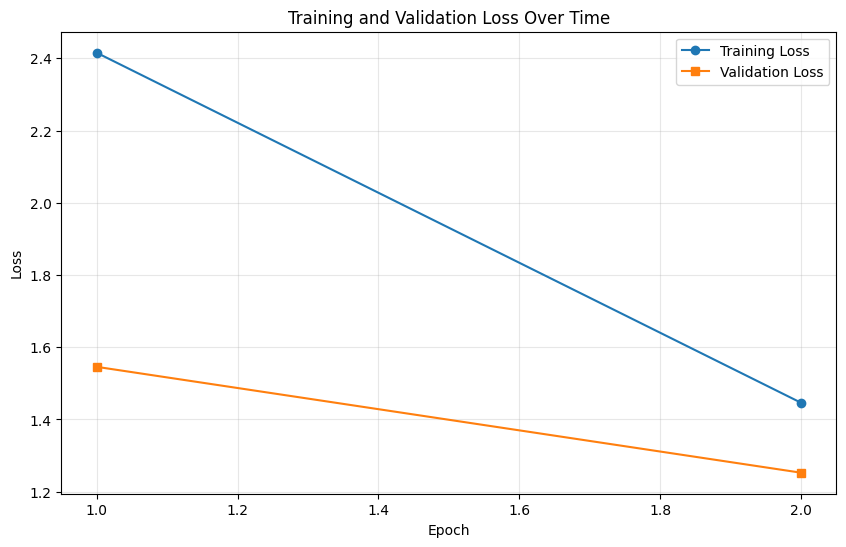

Final Training Loss: 1.4459
Final Validation Loss: 1.2524
Best Validation Loss: 1.2524
Best Validation Loss at Epoch: 2


In [36]:
helper_utils.plot_training_history(history)

## 5.5 Generating Translations with the Trained Model

Now that you've trained your encoder-decoder model, it's time to see it in action! In this section, you'll implement a translation function that takes an English sentence and generates its translation in your target language.

### How Translation Generation Works

Unlike training (where you have the complete target sequence), during inference you need to generate the translation token by token. This process is called **autoregressive generation**:

1. **Start with `<sos>`**: Begin the target sequence with the start-of-sequence token
2. **Generate one token at a time**: Feed the current partial translation to the decoder
3. **Select the next word**: Choose the most likely next token from the model's predictions
4. **Repeat**: Add the predicted token to the sequence and continue
5. **Stop at `<eos>`**: End generation when the model predicts the end-of-sequence token

### Greedy Decoding

The implementation below uses **greedy decoding** - at each step, you simply choose the token with the highest probability. While this doesn't always produce the best translation (beam search would be better), it's simple and effective for demonstration purposes.

### The Translation Function

The following function handles the complete translation pipeline:
- Preprocessing the input sentence (tokenization, conversion to indices)
- Managing padding and tensor formatting
- Performing the autoregressive generation
- Converting the output back to readable text

In [37]:
def translate_sentence(model, sentence, src_word2idx, tgt_idx2word, tokenizer, max_length=20, temperature=1.0, debug=False):
    """
    Translate a single sentence using greedy decoding with optional temperature sampling
    """
    model.eval()
    
    # Create reverse mapping for target vocabulary
    tgt_word2idx = {word: idx for idx, word in tgt_idx2word.items()}
    
    # Tokenize and convert to indices
    tokens = tokenizer(sentence.lower())
    src_indices = [src_word2idx.get(token, src_word2idx['<unk>']) for token in tokens]
    
    if debug:
        print(f"Input tokens: {tokens}")
        print(f"Input indices: {src_indices}")
    
    # Pad source to max_length
    if len(src_indices) < max_length:
        src_indices = src_indices + [src_word2idx['<pad>']] * (max_length - len(src_indices))
    else:
        src_indices = src_indices[:max_length]
    
    # Convert to tensor and add batch dimension
    src_tensor = torch.tensor(src_indices).unsqueeze(0).to(device)
    
    # Generate translation using autoregressive decoding
    with torch.no_grad():
        # Get encoder output and source padding mask
        encoder_memory, src_padding_mask = model.encoder(src_tensor)
        
        if debug:
            print(f"Encoder memory shape: {encoder_memory.shape}")
            print(f"Source padding mask shape: {src_padding_mask.shape}")
        
        # Start with <sos> token
        tgt_indices = [tgt_word2idx['<sos>']]
        
        for step in range(max_length - 1):
            # Create target tensor with only tokens generated so far
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            
            # Pass to decoder with encoder memory
            decoder_output = model.decoder(
                tgt_tensor, 
                memory=encoder_memory,
                memory_padding_mask=src_padding_mask
            )
            
            # Get prediction for the NEXT token (from last position)
            next_token_logits = decoder_output[0, -1, :]  # Last position predicts next token
            
            if debug and step < 3:
                print(f"Step {step}: Logits shape: {next_token_logits.shape}")
                print(f"Step {step}: Top 5 logits: {torch.topk(next_token_logits, 5)}")
            
            # Apply temperature for more diverse sampling
            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature
            
            # Use sampling instead of pure greedy for better diversity
            if temperature > 1.0:
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1).item()
            else:
                next_token = torch.argmax(next_token_logits).item()
            
            if debug and step < 3:
                print(f"Step {step}: Selected token: {next_token} ({tgt_idx2word.get(next_token, 'UNK')})")
            
            # Add predicted token to sequence
            tgt_indices.append(next_token)
            
            # Stop if <eos> token is generated
            if next_token == tgt_word2idx['<eos>']:
                break
    
    # Convert indices to words (exclude special tokens)
    translated_tokens = [tgt_idx2word[idx] for idx in tgt_indices 
                        if idx not in [tgt_word2idx['<pad>'], tgt_word2idx['<sos>'], tgt_word2idx['<eos>']]]
    
    if debug:
        print(f"Final target indices: {tgt_indices}")
        print(f"Translated tokens: {translated_tokens}")
    
    return ' '.join(translated_tokens)

# Quick debug version
def debug_translate(model, sentence, src_word2idx, tgt_idx2word, tokenizer, max_length=20):
    """Debug version with temperature and verbose output"""
    print(f"\n🔍 DEBUG: Translating '{sentence}'")
    print("=" * 50)
    
    # Try with different temperatures
    print("\n1. Greedy (temperature=1.0):")
    result1 = translate_sentence(model, sentence, src_word2idx, tgt_idx2word, tokenizer, 
                               max_length, temperature=1.0, debug=True)
    print(f"Result: '{result1}'")
    
    print("\n2. With temperature=1.5:")
    result2 = translate_sentence(model, sentence, src_word2idx, tgt_idx2word, tokenizer, 
                               max_length, temperature=1.5, debug=False)
    print(f"Result: '{result2}'")
    
    print("\n3. With temperature=2.0:")
    result3 = translate_sentence(model, sentence, src_word2idx, tgt_idx2word, tokenizer, 
                               max_length, temperature=2.0, debug=False)
    print(f"Result: '{result3}'")
    
    return result1

### 6.2 Test Translation on Training Examples

First, you'll test the translation on some examples from the training set to see if the model learned the patterns.

In [38]:
# Test on some training examples
print("Testing on training examples:")
print("=" * 60)

# Select a few examples from the training set
test_indices = [0, 100, 200, 300, 400]

for idx in test_indices:
    eng_sentence, fra_reference = normalized_pairs[idx]
    
    # Translate
    translation = translate_sentence(model, eng_sentence, eng_word2idx, tgt_idx2word, tokenizer)
    
    print(f"English:    {eng_sentence}")
    print(f"Reference:  {fra_reference}")
    print(f"Translated: {translation}")
    print("-" * 60)

Testing on training examples:
English:    go .
Reference:  va !
Translated: va !
------------------------------------------------------------
English:    go now .
Reference:  allez y maintenant .
Translated: va y .
------------------------------------------------------------
English:    beat it .
Reference:  va t en !
Translated: <unk> le .
------------------------------------------------------------
English:    go away .
Reference:  décampe !
Translated: va .
------------------------------------------------------------
English:    lock it .
Reference:  verrouillez la .
Translated: ferme le .
------------------------------------------------------------


## 7 - Conclusion

Great job completing this assignment! You've successfully built a complete encoder-decoder transformer architecture for machine translation from scratch.

### What You Built

Throughout this assignment, you implemented:

- An encoder that processes and understands source language sentences
- A decoder that generates translations in the target language  
- The complete translation system that combines both components
- A training pipeline that teaches the model to translate between languages
- An inference system that generates translations for new sentences

### Key Concepts You've Mastered

By completing this implementation, you now understand:

1. How encoders create contextualized representations of input text
2. How decoders generate output sequences using cross-attention to the encoder
3. The role of attention masks in handling variable-length sequences and preventing information leakage
4. The difference between training (with teacher forcing) and inference (autoregressive generation)
5. How positional encodings give transformers awareness of word order

### Why This Matters

The architecture you built forms the foundation of modern machine translation systems and many other NLP applications. This encoder-decoder pattern appears in tasks ranging from text summarization to question answering. The hands-on experience you've gained implementing these components from scratch gives you deep insight into how state-of-the-art NLP models actually work.